In [1]:
import time
import glob


import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import (
    Input,
    Conv1D,
    MaxPooling1D,
    Dropout,
    BatchNormalization,
    Activation,
    Add,
    Dense,
    GlobalAveragePooling1D,
)
import keras.backend as K
# from easydl import clear_output
from sklearn.utils import shuffle

# from get_representations import *


In [11]:
# indexes = [i for i in range(26,44)]

def load_data(tp:str):
    """
    tp: test or train
    return: array (n,m)
    """
    ECG = []
    for x in glob.glob('/data/Exercise/sub_*.npz'):
        print(x)
        data = np.load(x)
        data = data['arr_0']
        data = tf.transpose(data,(0,2,1))
        for i in range(int(data.shape[0]/2)):
            ECG.append(np.concatenate([data[2*i][0],data[2*i+1][0]]))
    print("finish loading data")
    return np.array(ECG)

def load_label(tp:str):
    """
    tp: test or train
    return: array (n,m)
    """
    BP = []
    for x in glob.glob('/data/Exercise/sub_*.npz'):
        data = np.load(x)
        data = data['arr_1']
        for i in range(int(data.shape[0]/2)):
            BP.append(np.concatenate([data[2*i],data[2*i+1]]))
    print("finish loading label")
    return np.array(BP)


In [12]:
class LossHistory(keras.callbacks.Callback):
    # 函数开始时创建盛放loss与acc的容器
    def on_train_begin(self, logs={}):
        self.losses = {'batch': [], 'epoch': []}
        self.accuracy = {'batch': [], 'epoch': []}
        self.val_loss = {'batch': [], 'epoch': []}
        self.val_acc = {'batch': [], 'epoch': []}

    # 按照batch来进行追加数据
#     def on_batch_end(self, batch, logs={}):
#         # 每一个batch完成后向容器里面追加loss，acc
#         self.losses['batch'].append(logs.get('loss'))
#         self.accuracy['batch'].append(logs.get('acc'))
#         self.val_loss['batch'].append(logs.get('val_loss'))
#         self.val_acc['batch'].append(logs.get('val_acc'))
#         # 每五秒按照当前容器里的值来绘图
#         if int(time.time()) % 5 == 0:
#             self.draw_p(self.losses['batch'], 'loss', 'train_batch')
#             self.draw_p(self.accuracy['batch'], 'acc', 'train_batch')
#             self.draw_p(self.val_loss['batch'], 'loss', 'val_batch')
#             self.draw_p(self.val_acc['batch'], 'acc', 'val_batch')

#     def on_epoch_end(self, batch, logs={}):
#         # 每一个epoch完成后向容器里面追加loss，acc
#         self.losses['epoch'].append(logs.get('loss'))
#         self.accuracy['epoch'].append(logs.get('acc'))
#         self.val_loss['epoch'].append(logs.get('val_loss'))
#         self.val_acc['epoch'].append(logs.get('val_acc'))
#         # 每五秒按照当前容器里的值来绘图
#         if int(time.time()) % 5 == 0:
#             self.draw_p(self.losses['epoch'], 'loss', 'train_epoch')
#             self.draw_p(self.accuracy['epoch'], 'acc', 'train_epoch')
#             self.draw_p(self.val_loss['epoch'], 'loss', 'val_epoch')
#             self.draw_p(self.val_acc['epoch'], 'acc', 'val_epoch')

    # 绘图，这里把每一种曲线都单独绘图，若想把各种曲线绘制在一张图上的话可修改此方法
    def draw_p(self, lists, label, type):
        plt.figure()
        plt.plot(range(len(lists)), lists, 'r', label=label)
        plt.ylabel(label)
        plt.xlabel(type)
        plt.legend(loc="upper right")
        plt.savefig(type + '_' + label + '.jpg')

    # 由于这里的绘图设置的是5s绘制一次，当训练结束后得到的图可能不是一个完整的训练过程（最后一次绘图结束，有训练了0-5秒的时间）
    # 所以这里的方法会在整个训练结束以后调用
    def end_draw(self):
        self.draw_p(self.losses['batch'], 'loss', 'train_batch')
        self.draw_p(self.accuracy['batch'], 'acc', 'train_batch')
        self.draw_p(self.val_loss['batch'], 'loss', 'val_batch')
        self.draw_p(self.val_acc['batch'], 'acc', 'val_batch')
        self.draw_p(self.losses['epoch'], 'loss', 'train_epoch')
        self.draw_p(self.accuracy['epoch'], 'acc', 'train_epoch')
        self.draw_p(self.val_loss['epoch'], 'loss', 'val_epoch')
        self.draw_p(self.val_acc['epoch'], 'acc', 'val_epoch')


logs_loss = LossHistory()



In [13]:
def normalization(data):
    """
    only for data
    data: 2d array 
    """
    print(data.shape)
    assert len(data.shape)==2
    
    for index,line in enumerate(data):
        max_ = line.max()
        min_ = line.min()
        data[index] = (line-min_)/(max_-min_)
    return data

def innormal(data):
    """
    反向归一化  209.506413847982 27.653349926908
    """
    up = 209.506413847982
    down = 27.653349926908
    differ = up-down
    return differ*data + down

def normal(label):
    """
    only for label !!!
    only for label !!!
    only for label !!!
    """
    up = label.max()
    down = label.min()
    differ = up-down
    print(up, down)
    return (label-down)/differ

In [37]:
# 读取数据 防误触注释
train_data = load_data('train')
train_label = load_label('train') # (11659, 4)

# test_data = load_data('val')
# test_label = load_label('val') # (1244, 4)

# clear_output()
train_data.shape

/data/Exercise/sub_26.npz
/data/Exercise/sub_27.npz
/data/Exercise/sub_28.npz
/data/Exercise/sub_31.npz
/data/Exercise/sub_29.npz
/data/Exercise/sub_30.npz
/data/Exercise/sub_32.npz
/data/Exercise/sub_33.npz
/data/Exercise/sub_36.npz
/data/Exercise/sub_37.npz
/data/Exercise/sub_38.npz
/data/Exercise/sub_42.npz
/data/Exercise/sub_35.npz
/data/Exercise/sub_34.npz
/data/Exercise/sub_39.npz
/data/Exercise/sub_40.npz
/data/Exercise/sub_41.npz
/data/Exercise/sub_43.npz
finish loading data
finish loading label


(11659, 10000)

In [21]:
# 拼接在一起的数据是不连续的，这是因为师兄的数据分割方法造成的
# plt.scatter([i for i in range(100)],train_data[1][4950:4950+100])

In [22]:
# 看验证集大小
train_data.min()

-0.0038566923948343

In [38]:
# 两份数据拼在一起，统一降采样，归一化
# data = np.concatenate([train_data,test_data])
# label = np.concatenate([train_label,test_label])
data = train_data
label = train_label

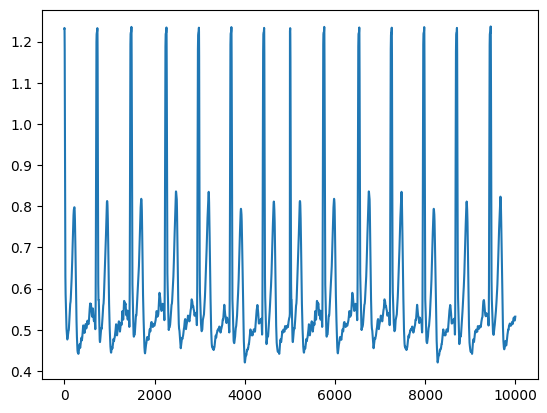

In [39]:
# plt.plot(label[11659:])
# plt.plot(data[11698])
plt.plot(data[11609])

In [55]:
# 重采样
data_ = np.zeros((data.shape[0],4096))
for i in range (data.shape[0]):
    data_[i] = scipy.signal.resample_poly(data[i],4096,10000)
print("finish resample")

# 检查重采样后的维度
print(data_.shape)
print(label.shape)
# 209.506413847982 27.653349926908 血压最大值和最小值

finish resample
(11659, 4096)
(11659, 4)


In [56]:
# 归一化
# data_ = normalization(data_)
# label = normal(label)

In [57]:
# shuffle不能完全打乱val和train 因为个体ecg特征会利于估计val中的血压
data_[:11659], label[:11659] = shuffle(data_[:11659], label[:11659], random_state=1)
# data_[11659:], label[11659:] = shuffle(data_[11659:], label[11659:], random_state=2)
# data_[:10000], label[:10000] = shuffle(data_[:10000], label[:10000], random_state=1)
# data_[10000:], label[10000:] = shuffle(data_[10000:], label[10000:], random_state=2)
# data_, label = shuffle(data_, label, random_state=2)

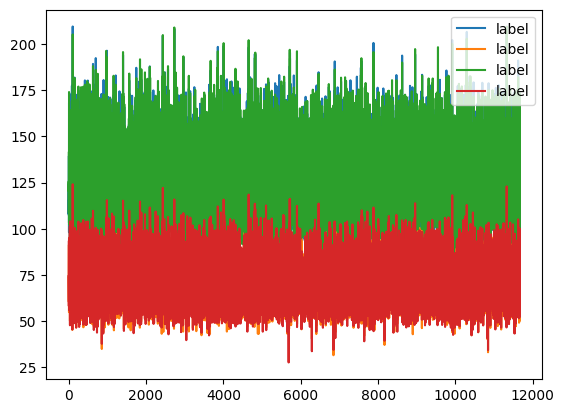

In [58]:
# 验证shuffle成效
plt.plot(label, label='label') 
plt.legend()

In [59]:
np.save('/data/Exercise/experiment/test/train_data.npy',data_[:10000])
np.save('/data/Exercise/experiment/test/test_data.npy',data_[10000:])
np.save('/data/Exercise/experiment/test/train_label.npy',label[:10000])
np.save('/data/Exercise/experiment/test/test_label.npy',label[10000:])

# 训练





In [60]:
train_data = np.load('/data/Exercise/experiment/test/train_data.npy')
test_data = np.load('/data/Exercise/experiment/test/test_data.npy')

train_label = np.load('/data/Exercise/experiment/test/train_label.npy')
test_label = np.load('/data/Exercise/experiment/test/test_label.npy')
# train_label = np.load('/home/ubuntu/data/Exercise/normalization/train_label.npy')
# test_label = np.load('/home/ubuntu/data/Exercise/normalization/test_label.npy')


print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

print(test_label[1])
print(train_label.max())
print(train_label.min())

(10000, 4096)
(10000, 4)
(1659, 4096)
(1659, 4)
[121.21392651  78.44141374 120.28279465  78.63804107]
209.506413847982
27.653349926908


In [ ]:
plt.plot(train_data[11609])

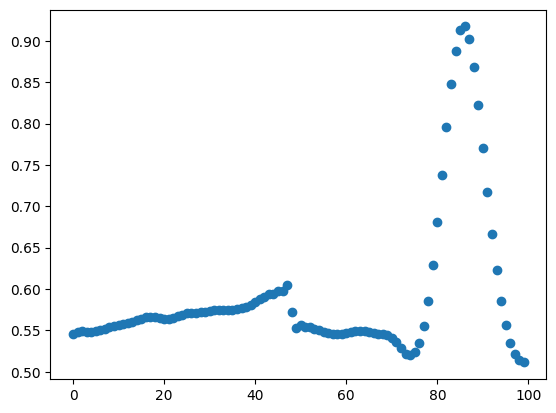

In [16]:
plt.scatter([i for i in range(100)],test_data[10][2000:2100])

In [17]:
# clear_output()
pclr = load_model('./PCLR_lead_I_finetune.h5')
pclr.summary()
# clear_output()

Model: "functional_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ecg (InputLayer)               [(None, 4096, 1)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 4096, 64)     1024        ['ecg[0][0]']                    
                                                                                                  
 batch_normalization (BatchNorm  (None, 4096, 64)    256         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 4096, 64)     0           ['batch_normalization[

In [18]:
length = 32
model = tf.keras.models.Sequential()
model.add(pclr)  # 记得改模型名称
model.add(Dense(length*10,activation='relu'))
model.add(Dense(length*5,activation='relu'))
# model.add(Dense(length*2,activation='relu'))
model.add(Dense(length,activation='relu'))
model.add(Dense(4)) # sbp dbp sbp dbp
model.layers[0].trainable = False
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 functional_1 (Functional)   (None, 320)               6383648   
                                                                 
 dense (Dense)               (None, 320)               102720    
                                                                 
 dense_1 (Dense)             (None, 160)               51360     
                                                                 
 dense_2 (Dense)             (None, 32)                5152      
                                                                 
 dense_3 (Dense)             (None, 4)                 132       
                                                                 
Total params: 6,543,012
Trainable params: 159,364
Non-trainable params: 6,383,648
_________________________________________________________________


In [19]:
# model = keras.models.load_model('./mse/mse-320-160-32-4-179-21.80.h5')
# clear_output()

In [20]:
# def mean_squared_error(y_true, y_pred): # 均方误差
#     return K.mean(K.square(y_pred - y_true), axis=-1)
length = 32
epoch=500 # 前200个epoch不需要保存
# epoch=300
batch_size=256
lr = 0.0001
tp='mse'
# tp='msle'
opt = keras.optimizers.Adam(learning_rate=lr)
# opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=False, decay=0.1, name="SGD")
model.compile(optimizer=opt, loss=tp)

model_name = '../zml_models/experiment/mse-adam-4445-320-160-32-4-{epoch:02d}-{val_loss:.2f}.h5'
checkpoint = ModelCheckpoint(filepath=model_name, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             save_best_value=True,
                             initial_value_threshold=30)
callback_list = [checkpoint]

h = model.fit(train_data,train_label, 
              validation_data=(test_data,test_label), 
              epochs=epoch, 
              batch_size=batch_size, 
              shuffle=True, 
#               callbacks=callback_list
             )

Epoch 1/500


2022-12-07 20:49:27.756424: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8303


46/46 [==============================] - 8s 101ms/step - loss: 8026.7373 - val_loss: 4820.4116
Epoch 2/500
46/46 [==============================] - 3s 70ms/step - loss: 1890.5768 - val_loss: 480.4706
Epoch 3/500
46/46 [==============================] - 3s 71ms/step - loss: 405.2073 - val_loss: 369.1051
Epoch 4/500
46/46 [==============================] - 3s 71ms/step - loss: 323.1696 - val_loss: 301.9425
Epoch 5/500
46/46 [==============================] - 3s 71ms/step - loss: 263.8764 - val_loss: 248.6975
Epoch 6/500
46/46 [==============================] - 3s 71ms/step - loss: 216.3642 - val_loss: 205.7137
Epoch 7/500
46/46 [==============================] - 3s 70ms/step - loss: 179.5984 - val_loss: 173.0722
Epoch 8/500
46/46 [==============================] - 3s 71ms/step - loss: 151.4422 - val_loss: 147.4258
Epoch 9/500
46/46 [==============================] - 3s 71ms/step - loss: 128.6557 - val_loss: 125.8193
Epoch 10/500
46/46 [==============================] - 3s 71ms/step - los

KeyboardInterrupt: 

In [15]:
length = 32

In [17]:
# model.save('../zml_models/withoutnormal--Dense160-{length}-4&lr={lr}&epoch={epoch}&batchsize={batchsize}&RMSE.h5'
#            .format(length=length,epoch=epoch+100,batchsize=batch_size,lr=lr))
# 模型名称没说明loss的默认mse，

In [9]:
# Plot accuracy and loss curve
history = h.history
print(history.keys())
epochs = range(len(history['loss']))

plt.figure(figsize=(20, 5))
# ax = plt.subplot(1, 2, 1)
# ax.set_title('Train and Valid Accuracy')
# plt.plot(epochs, history['accuracy'], 'b', label='Train accuracy')
# plt.plot(epochs, history['val_accuracy'], 'r', label='Valid accuracy')
# plt.legend()

ax = plt.subplot(1, 2, 2)
ax.set_title('Train and Valid Loss')
plt.plot(epochs, history['loss'], 'b', label='Train loss')
plt.plot(epochs, history['val_loss'], 'r', label='Valid loss')
plt.xlabel('epoch')
plt.ylabel('total loss')
plt.legend()

NameError: name 'h' is not defined

# 评估

In [61]:
# file_name = 'withoutnormal--Dense160-32-4&lr=0.001&epoch=200&batchsize=256.h5'
# m = load_model('../zml_models/'+file_name)
m = load_model('/home/ubuntu/ml4h/ml4h/model_zoo/PCLR/zml/mse/mse-320-160-32-4-137-20.90.h5')
# clear_output()

In [36]:
# plt.plot(test_data[1])
test_data.max()

1.0

In [4]:
test_data.shape

(1244, 4096)

In [62]:
test_data.shape
print(test_data.shape)

res = m.predict(test_data)
print(res[0])
print(test_label[0])
print(res.shape)

(1659, 4096)
[133.00801   75.03838  149.1911    76.842064]
[101.76299667  53.97392273 104.5639493   55.54411634]
(1659, 4)


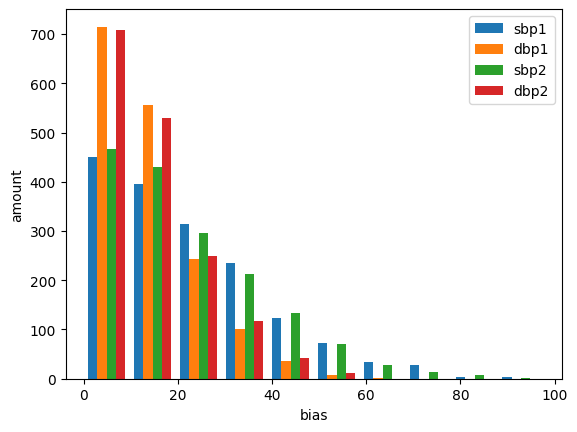

In [63]:
# print(res)
# r = innormal(res)
# print(r)
# print(test_label[0:256])
differ = abs(res-test_label)
plt.hist(differ,label=['sbp1','dbp1','sbp2','dbp2'])
plt.xlabel('bias')
plt.ylabel('amount')
plt.legend()

# clear_output()

0.005549519722123364


[]

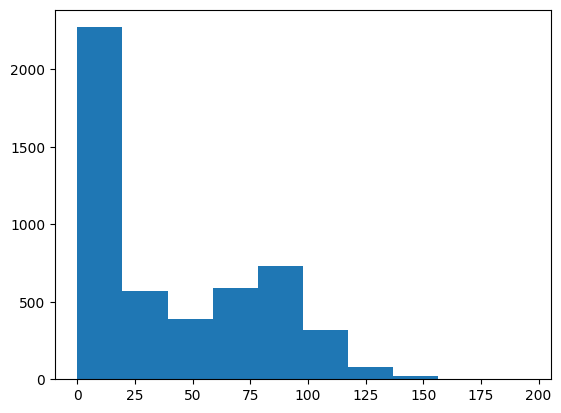

In [12]:
x = np.ndarray.flatten(differ)
x.sort()
# print(x)
print(x[1])
plt.hist(x,label=['sbp1','dbp1','sbp2','dbp2'])
plt.plot()
# x

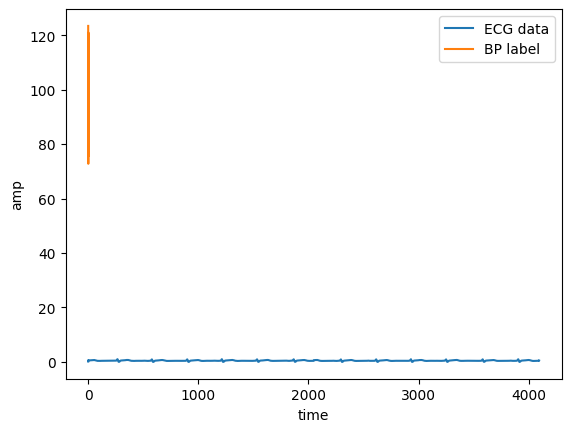

In [13]:
plt.plot(test_data[255],label='ECG data')
plt.plot(test_label[255],label='BP label')
plt.xlabel('time')
plt.ylabel('amp')
plt.legend() 

In [51]:
# 数数
def BHS_standard(predict, test):
    total = len(predict)
    mm5 = np.sum(np.abs(predict-test)<=5.0)
    mm10 = np.sum(np.abs(predict-test)<=10.0)
    mm15 = np.sum(np.abs(predict-test)<=15.0)
    return total, mm5, mm10, mm15

In [52]:
# res=m.predict(test_data)

In [53]:
t_data = tf.transpose(test_label,(1,0))
predict_data = tf.transpose(res,(1,0))
predict_data.dtype # 检查数据类型，发现predict是float32，label是float64
predict_data = tf.cast(predict_data,dtype='float64') 

total, mm5, mm10, mm15 = BHS_standard(t_data[0],predict_data[0])

In [54]:
print()
print('-------------BHS standard------------')
print('<5mmHg        <10mmHg        <15mmHg        total')
print('%d            %d           %d          %d' % (mm5,mm10,mm15,total))
print('%.3f%s        %.3f%s       %.3f%s         %d' % (mm5/total*100, '%',mm10/total*100, '%',mm15/total*100, '%', total))


-------------BHS standard------------
<5mmHg        <10mmHg        <15mmHg        total
550            943           1226          1659
33.153%        56.841%       73.900%         1659
